# Figure 6

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sys
import os
from tqdm import tqdm
import imageio
import cv2
import scipy
from itertools import product
# enables the %%R magic
import rpy2.ipython
%load_ext rpy2.ipython
import shutil

sys.path.append("./utils")
from myUtils import mkdir
from caAnalysisUtils import RunSimulation, PlotSimulation_CA, GenerateATComparisonPlot_CA, \
GenerateATComparisonPlot_ODE, PlotCompetitionOverTime


# Format plots
sns.set(style="white",
        font_scale=2.,
        font="Serif",
        rc={'figure.figsize':(12,6)})

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [26]:
### Script parameters
colorDic = {'MTD':'#FF9409','AT50':'#094486'}
txComparisonDf = pd.read_csv("./data/n0Sweep.csv",index_col=0) # TTP comparison data from plots/analysis in Figure 2
runCASimulations = True # Whether to run the CA simulations to generate the data analysed in this script

## a) Pie Charts showing distributions of outcomes

cost_0.00_turnover_0.00: 
[89.60000000000001, 10.2, 0.0, 0.2, 0.0]
cost_0.00_turnover_0.30: 
[72.0, 25.8, 2.1, 0.1, 0.0]
cost_0.30_turnover_0.00: 
[89.3, 10.4, 0.0, 0.3, 0.0]
cost_0.30_turnover_0.30: 
[56.2, 26.700000000000003, 7.9, 0.1, 9.1]
cost_0.00_turnover_0.00: 
[100.0, 0.0, 0.0, 0.0, 0.0]
cost_0.00_turnover_0.30: 
[87.3, 11.799999999999999, 0.1, 0.0, 0.8]
cost_0.30_turnover_0.00: 
[99.8, 0.2, 0.0, 0.0, 0.0]
cost_0.30_turnover_0.30: 
[36.5, 9.2, 1.7000000000000002, 0.1, 52.5]


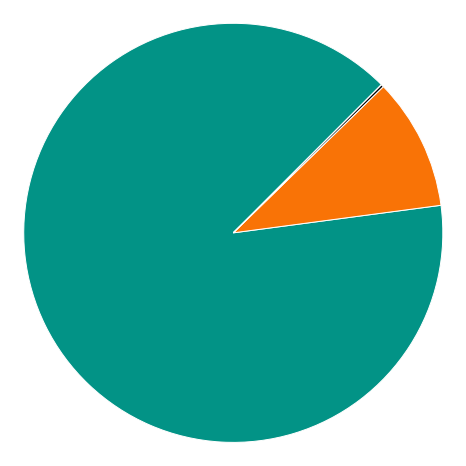

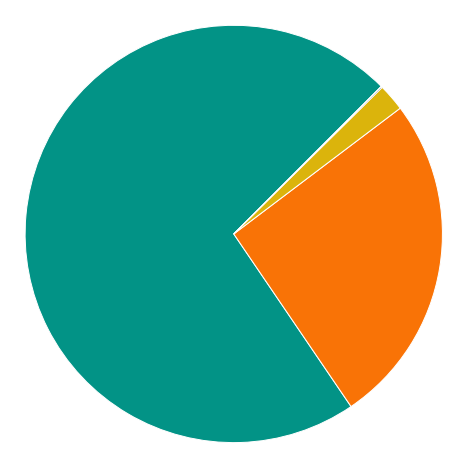

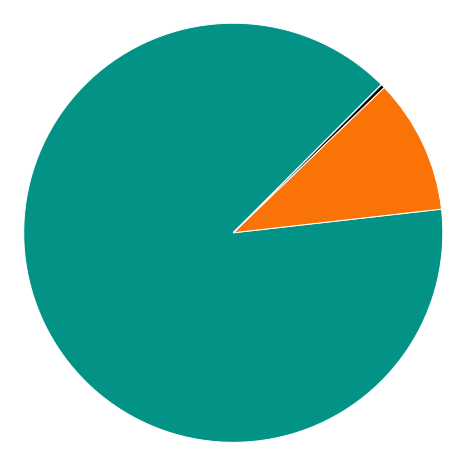

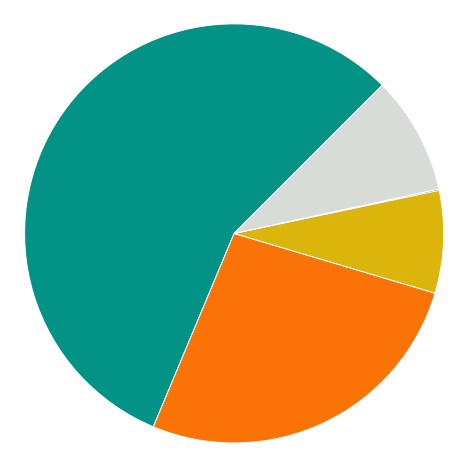

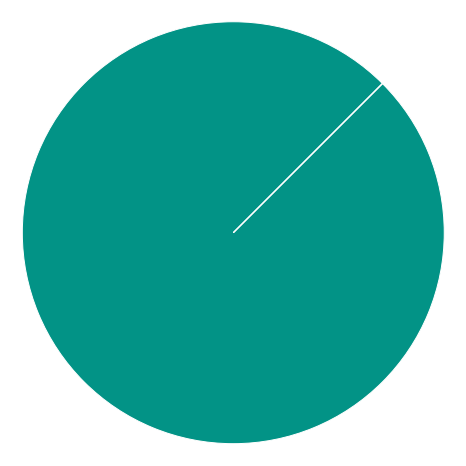

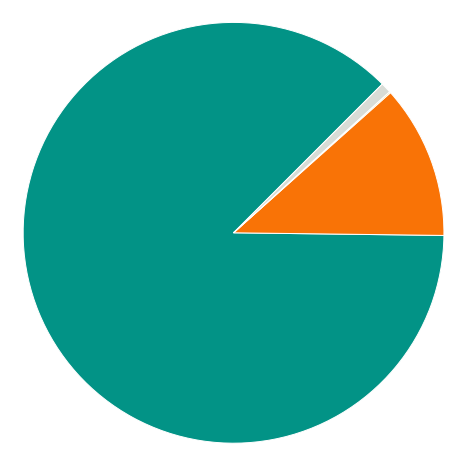

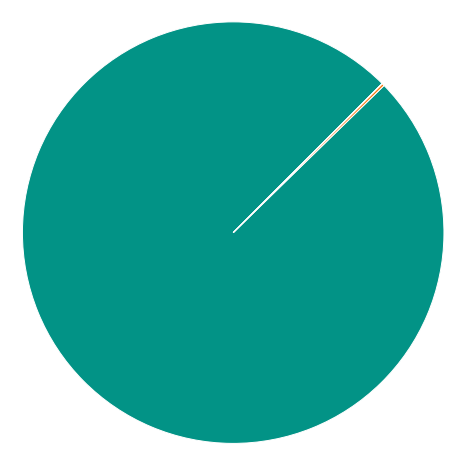

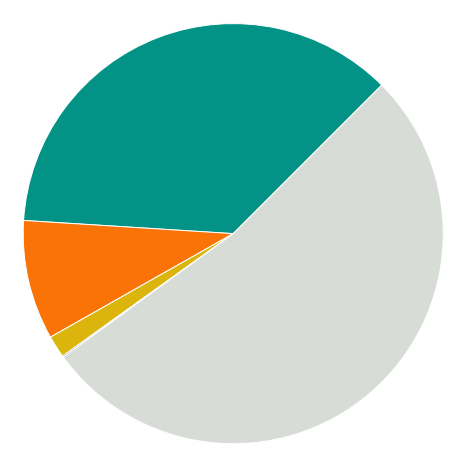

In [18]:
initialSize = 0.25
rFrac = 0.001

for initialSize in [0.25, 0.5]:
    for cost,turnover in product([0,0.3],[0,0.3]):
        currDf = txComparisonDf[(txComparisonDf.InitialTumourSize==initialSize) & 
                       (txComparisonDf.RFrac==rFrac) & 
                       (txComparisonDf.Cost==cost) & 
                       (txComparisonDf.Turnover==turnover)]

        # Extract outcomes
        nCured = np.sum(currDf.FinalSize_R_CT==0)
        nSuperior_AT = np.sum(currDf.RelTimeGained_CA>0) + np.sum((currDf.FinalSize_R_AT==0)&(currDf.FinalSize_R_CT>0))
        nSuperior_CT = np.sum(currDf.RelTimeGained_CA<0)
        nEqual = np.sum(currDf.RelTimeGained_CA==0)
        nNotCompleted = np.sum((np.isnan(currDf.RelTimeGained_CA))&(currDf.FinalSize_R_AT>0)&(currDf.FinalSize_R_CT>0))
        assert(nCured+nSuperior_AT+nSuperior_CT+nEqual+nNotCompleted==1000)

        # Pie chart, where the slices will be ordered and plotted counter-clockwise:
        labels = ['AT>CT','AT<CT','Cure','Equal','Not Completed']
        sizes = [nSuperior_AT, nSuperior_CT, nCured, nEqual, nNotCompleted]
        print("cost_%1.2f_turnover_%1.2f: "%(cost,turnover))
        print([x/1000*100 for x in sizes])
        fig1, ax1 = plt.subplots(figsize=(7,7))
        ax1.pie(sizes, #autopct='%1.1f%%', #labels=labels, 
                colors=sns.xkcd_palette(["teal","orange","gold","black","light grey"]),
                shadow=False, startangle=45)
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.tight_layout()
        plt.savefig("./figures/outcomeDist_n0_%1.2f_cost_%1.2f_turnover_%1.2f.pdf"%(initialSize,cost,turnover))

## e) Role of the domain size

Note: data collected using `collectData_domainSizeComparison.py`

In [51]:
varyDomainSizeDataDf = pd.read_csv("../varyDomainSize/varyDomainSize.csv",index_col=0)
varyDomainSizeDataDf['Cost'] *= 100

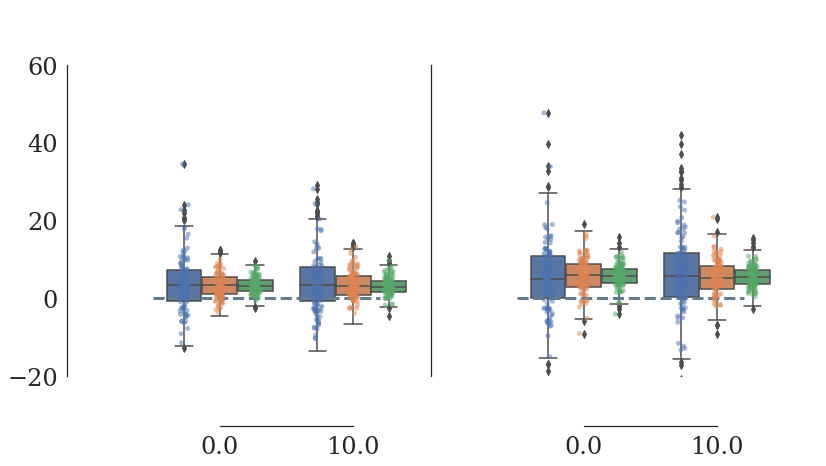

In [55]:
rFrac = 0.01
initialSize = 0.3
currDataDf = varyDomainSizeDataDf[(varyDomainSizeDataDf.InitialTumourSize==initialSize) &
                                  (varyDomainSizeDataDf.RFrac==rFrac)]

fig,axList = plt.subplots(1,2,sharex=True,sharey=True,figsize=(12,7))
for i,turnover in enumerate(varyDomainSizeDataDf.Turnover.unique()):
    currDataDf = varyDomainSizeDataDf[(varyDomainSizeDataDf.InitialTumourSize==initialSize) &
                                      (varyDomainSizeDataDf.RFrac==rFrac) & 
                                      (varyDomainSizeDataDf.Turnover==turnover)]
    ax = axList[i]
    sns.stripplot(x="Cost",y="RelTimeGained_CA",alpha=0.5,dodge=True,
                 hue="DomainSize", 
                  ax=ax,data=currDataDf[::10])
    sns.boxplot(x="Cost",y="RelTimeGained_CA",dodge=True,
                 hue="DomainSize", 
                 ax=ax,data=currDataDf)
    ax.plot(np.linspace(-0.5,.8*ax.get_xlim()[1],100),
            np.repeat(0,100),color=sns.xkcd_rgb['blue grey'],lw=3,ls='--')
    ax.set_ylim(-20,75)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(labelsize=24)
    ax.get_legend().remove()
    sns.despine(ax=ax,offset=50, trim=True)
plt.tight_layout()
# plt.savefig("./figures/varyDomainSize.pdf")

## c) & d) Example of failure because of different colony numbers

In [31]:
initialSize = 0.25
rFrac = 0.001

txComparisonDf['AbsTimeGained_CA'] = txComparisonDf.TTP_AT50_CA-txComparisonDf.TTP_CT_CA
currDf = txComparisonDf[(txComparisonDf.InitialTumourSize==initialSize) & 
               (txComparisonDf.RFrac==rFrac)]
currDf.reset_index(inplace=True)
# currDf = txComparisonDf[(txComparisonDf.InitialTumourSize==initialSize) & 
#                (txComparisonDf.RFrac==rFrac) & 
#                (txComparisonDf.Cost==cost) & 
#                (txComparisonDf.Turnover==turnover)]

worstCase = currDf.loc[currDf.AbsTimeGained_CA.argmin()]
worstCase

index                     612.000000
Cost                        0.300000
FinalSize_R_AT           3018.000000
FinalSize_R_CT           3006.000000
InitialTumourSize           0.250000
MaxNCycles                 12.000000
RFrac                       0.001000
RelTimeGained_CA          -51.613809
ReplicateId               612.000000
SuppressionDiff_Abs     28172.592199
SuppressionDiff_Mean       -1.213521
SuppressionDiff_Sq       1111.857350
SuppressionDiff_Sum     -1578.791426
TTP_AT50_CA              1724.000000
TTP_CT_CA                3563.000000
Turnover                    0.300000
AbsTimeGained_CA        -1839.000000
Name: 3612, dtype: float64

In [43]:
# Params for the figure
initialSize = worstCase.InitialTumourSize
rFrac = worstCase.RFrac
nReplicates = 1
tEnd = 4000
seedToShowImagesFor = int(worstCase.ReplicateId)
dataDir = "./data/atFailure_exampleSim/data/"
imgDir = "./data/atFailure_exampleSim/images/"

### Collect Data

In [44]:
# Collect the data for one replicate
if runCASimulations:
    modelConfigDic = {"initialSize":initialSize,"rFrac":rFrac,"turnover":worstCase.Turnover,"cost":worstCase.Cost,
                      "tEnd":tEnd,"seed":seedToShowImagesFor,"nReplicates":1,
                      "profilingMode":"false","terminateAtProgression":"false","outDir":dataDir}
    RunSimulation(modelConfigDic)

In [49]:
# Collect the images for one replicate
if runCASimulations:
    modelConfigDic = {"initialSize":initialSize,"rFrac":rFrac,"turnover":worstCase.Turnover,"cost":worstCase.Cost,
                      "tEnd":1500,"seed":seedToShowImagesFor,"nReplicates":1,
                      "profilingMode":"false","terminateAtProgression":"true",
                      "imageOutDir":imgDir,"imageFreq":250,
                      "outDir":"./scratch/"}
    RunSimulation(modelConfigDic)

### c) Plot Simulation

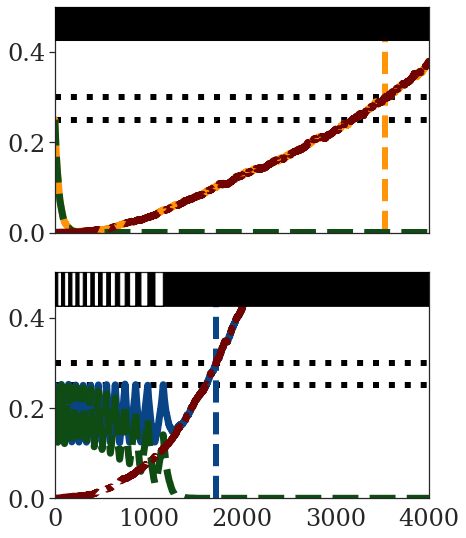

In [46]:
replicateId = seedToShowImagesFor
fig, axList = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(7, 8))
for i,txName in enumerate(["MTD","AT50"]):
    tmpList = []
    currDfName = os.path.join(dataDir,"%s_cellCounts_cost_%1.1f_rFrac_%.2g_initSize_%.2g_dt_1.0_RepId_%d.csv"%(txName,cost*100,rFrac,initialSize,replicateId))
    tmpDf = pd.read_csv(currDfName)
    tmpDf['NCells'] /= 1e4
    tmpDf['NCells_S'] /= 1e4
    tmpDf['NCells_R'] /= 1e4
    tmpDf['ReplicateId'] = replicateId
    tmpDf['TreatmentBranch'] = txName
    tmpList.append(tmpDf)
    dataDf = pd.concat(tmpList)
    dataDf.rename(columns={"NCells":"V","NCells_S":"S","NCells_R":"R"},inplace=True)
    # Plot
    PlotSimulation_CA(dataDf,xlim=4e3,yLimVec=[0,0.5],
                      colorA=[colorDic[txName]],showProgression=True,
                      savefigB=True,ax=axList[i])
plt.tight_layout()
plt.savefig("./figures/exampleSim_atFailure_diffColonies.pdf")
    

### d) Plot Images

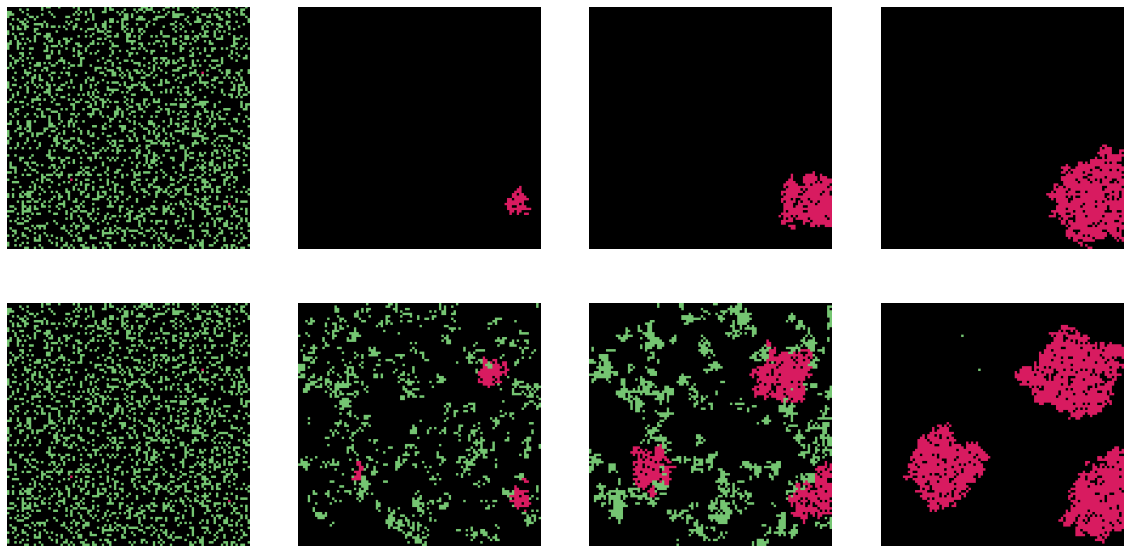

In [50]:
# timePointList = [0,250,500,750]
timePointList = [0,500,1000,1500]


fig,axList = plt.subplots(2,len(timePointList),figsize=(len(timePointList)*5,10))
for i,timePoint in enumerate(timePointList):
    for j,txName in enumerate(["MTD","AT50"]):
        # Load image
        currImgDir = os.path.join(imgDir,"%s_cost_%1.1f_rFrac_%.2g_initSize_%.2g_dt_1.0_RepId_%d"%(txName,cost*100,rFrac,initialSize,seedToShowImagesFor))
        currImg = cv2.imread(os.path.join(currImgDir,"img_t_%.1f.png"%(float(timePoint))))
        currImg = cv2.cvtColor(currImg, cv2.COLOR_BGR2RGB)

        currAx = axList[j,i]
        currAx.imshow(currImg)
        currAx.axis('off')
plt.savefig("figures/exampleSim_atFailure_diffColonies_images.pdf")

## e) & f) Example of failure because of tumour structure change

In [40]:
initialSize = 0.25
rFrac = 0.001
cost = 0
turnover = 0.

currDf = txComparisonDf[(txComparisonDf.InitialTumourSize==initialSize) & 
               (txComparisonDf.RFrac==rFrac) & 
               (txComparisonDf.Cost==cost) & 
               (txComparisonDf.Turnover==turnover)]

worstCase = currDf.loc[currDf.RelTimeGained_CA.argmin()]
worstCase

Cost                       0.000000
FinalSize_R_AT          2945.000000
FinalSize_R_CT          3006.000000
InitialTumourSize          0.250000
MaxNCycles                 3.000000
RFrac                      0.001000
RelTimeGained_CA          -9.102402
ReplicateId                7.000000
SuppressionDiff_Abs     8508.670962
SuppressionDiff_Mean       3.232680
SuppressionDiff_Sq       569.832027
SuppressionDiff_Sum     1942.840718
TTP_AT50_CA              719.000000
TTP_CT_CA                791.000000
Turnover                   0.000000
Name: 7, dtype: float64

In [41]:
# Params for the figure
initialSize = worstCase.InitialTumourSize
rFrac = worstCase.RFrac
nReplicates = 1
tEnd = 1000
seedToShowImagesFor = int(worstCase.ReplicateId)
dataDir = "./data/atFailure_noTurnover_exampleSim/data/"
imgDir = "./data/atFailure_noTurnover_exampleSim/images/"

### Collect Data

In [44]:
# Collect the data for one replicate
if runCASimulations:
    modelConfigDic = {"initialSize":initialSize,"rFrac":rFrac,"turnover":worstCase.Turnover,"cost":worstCase.Cost,
                      "tEnd":3000,"seed":seedToShowImagesFor,"nReplicates":1,
                      "profilingMode":"false","terminateAtProgression":"false","outDir":dataDir}
    RunSimulation(modelConfigDic)

In [42]:
# Collect the images for one replicate
if runCASimulations:
    modelConfigDic = {"initialSize":initialSize,"rFrac":rFrac,"turnover":worstCase.Turnover,"cost":worstCase.Cost,
                      "tEnd":tEnd,"seed":seedToShowImagesFor,"nReplicates":1,
                      "profilingMode":"false","terminateAtProgression":"false",
                      "imageOutDir":imgDir,"imageFreq":250,
                      "outDir":"./data/scratch/"}
    RunSimulation(modelConfigDic)

### e) Plot Simulation

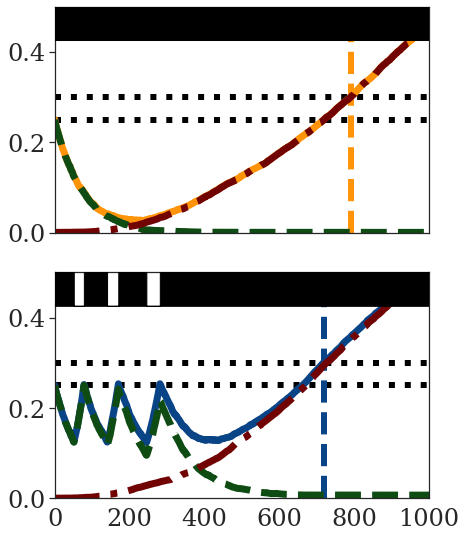

In [49]:
replicateId = seedToShowImagesFor
fig, axList = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(7, 8))
for i,txName in enumerate(["MTD","AT50"]):
    tmpList = []
    currDfName = os.path.join(dataDir,"%s_cellCounts_cost_%1.1f_rFrac_%.2g_initSize_%.2g_dt_1.0_RepId_%d.csv"%(txName,cost,rFrac,initialSize,replicateId))
    tmpDf = pd.read_csv(currDfName)
    tmpDf['NCells'] /= 1e4
    tmpDf['NCells_S'] /= 1e4
    tmpDf['NCells_R'] /= 1e4
    tmpDf['ReplicateId'] = replicateId
    tmpDf['TreatmentBranch'] = txName
    tmpList.append(tmpDf)
    dataDf = pd.concat(tmpList)
    dataDf.rename(columns={"NCells":"V","NCells_S":"S","NCells_R":"R"},inplace=True)
    # Plot
    PlotSimulation_CA(dataDf,xlim=1e3,yLimVec=[0,0.5],
                      colorA=[colorDic[txName]],showProgression=True,
                      savefigB=True,ax=axList[i])
plt.tight_layout()
plt.savefig("./figures/exampleSim_atFailure_tumourStructure.pdf")
    

#### Plot

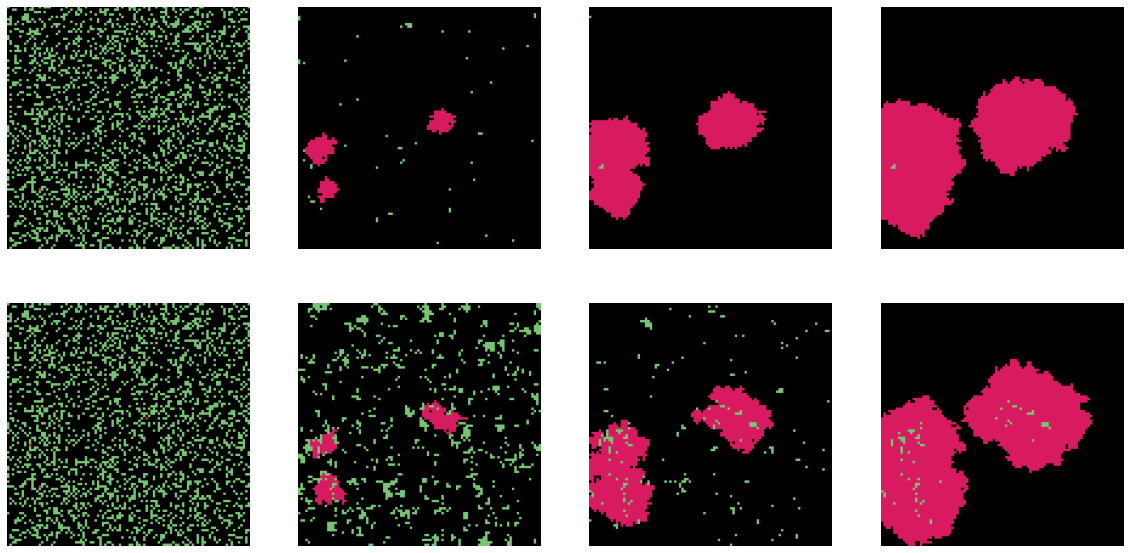

In [35]:
timePointList = [0,250,500,750]


fig,axList = plt.subplots(2,len(timePointList),figsize=(len(timePointList)*5,10))
for i,timePoint in enumerate(timePointList):
    for j,txName in enumerate(["MTD","AT50"]):
        # Load image
        currImgDir = os.path.join(imgDir,"%s_cost_%1.1f_rFrac_%.2g_initSize_%.2g_dt_1.0_RepId_%d"%(txName,cost*100,rFrac,initialSize,seedToShowImagesFor))
        currImg = cv2.imread(os.path.join(currImgDir,"img_t_%.1f.png"%(float(timePoint))))
        currImg = cv2.cvtColor(currImg, cv2.COLOR_BGR2RGB)

        currAx = axList[j,i]
        currAx.imshow(currImg)
        currAx.axis('off')
plt.savefig("figures/exampleSim_atFailure_noTurnover_images.pdf")